<a href="https://colab.research.google.com/github/kingsleyyeon/PrecisionMatEst/blob/main/PrecisionMatCholesky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import KDTree
from scipy.optimize import minimize, Bounds
import heapq

###############################################################################
# 1. Generate a Gaussian kernel matrix: A[i,j] = exp(-(i-j)^2/sigma)
###############################################################################
def generate_kernel_matrix(n, sigma=2.0):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A[i, j] = np.exp(-((i - j) ** 2) / sigma)
    # Ensure positive definiteness
    min_eig = np.min(np.linalg.eigvalsh(A))
    if min_eig < 1e-8:
        A += (1e-8 - min_eig) * np.eye(n)
    return A

###############################################################################
# 2. Compute the Cholesky sparsity pattern S using KDTree-based technique
###############################################################################
def boundary_dist_func(point):
    return np.linalg.norm(point)

def reverse_maximin_ordering(points):
    """
    Order points from furthest to closest from the origin.
    Returns a permutation (list of indices).
    """
    n = points.shape[0]
    ordering = []
    remaining = set(range(n))
    while remaining:
        max_dist = -1
        next_point = -1
        for i in remaining:
            dist = boundary_dist_func(points[i])
            if dist > max_dist:
                max_dist = dist
                next_point = i
        ordering.append(next_point)
        remaining.remove(next_point)
    return ordering

def compute_sparsity_pattern_perm(points, rho, max_neighbors):
    """
    For points in the permuted (elimination) order, compute a sparsity pattern.
    For each point i, we find all indices j (with j >= i) that satisfy:
         distance(points[i], points[j]) <= rho * boundary_dist(points[i]),
    then we sort them by distance and keep at most max_neighbors entries.
    We ensure that the diagonal index (i) is included and placed first.
    """
    n = points.shape[0]
    tree = KDTree(points)
    sparsity = [[] for _ in range(n)]
    for i in range(n):
        radius = rho * boundary_dist_func(points[i])
        # Find all indices within the given radius.
        neighbors = tree.query_ball_point(points[i], radius)
        # Only keep indices that are >= i.
        neighbors = [j for j in neighbors if j >= i]
        # Sort neighbors by distance from points[i]
        neighbors = sorted(neighbors, key=lambda j: np.linalg.norm(points[j] - points[i]))
        # Ensure that i appears first.
        if i not in neighbors:
            neighbors = [i] + neighbors
        else:
            neighbors.remove(i)
            neighbors = [i] + neighbors
        # Restrict to at most max_neighbors.
        sparsity[i] = neighbors[:max_neighbors]
    return sparsity

def compute_cholesky_sparsity_from_points(points, rho, max_neighbors):
    """
    Compute the Cholesky sparsity pattern using the KDTree-based method.
    The points are first ordered (reverse maximin), then the sparsity pattern is
    computed in that permuted order, and finally the pattern is returned in the
    original ordering.
    """
    ordering = reverse_maximin_ordering(points)
    points_perm = points[ordering]
    sparsity_perm = compute_sparsity_pattern_perm(points_perm, rho, max_neighbors)
    ip = np.argsort(ordering)  # inverse permutation
    n = points.shape[0]
    S = [None] * n
    for i in range(n):
        S[i] = [ordering[j] for j in sparsity_perm[ip[i]]]
    return S

###############################################################################
# 3. Reparameterize L using its free (nonzero) entries and solve:
#    minimize 0.5 * trace(YTY * (L L^T)) - m * sum(log(diag(L)))
#    subject to L[i,j] = 0 for j not in S[i] (with j<=i) and L[i,i] >= eps.
###############################################################################
def get_free_indices(S, n):
    """
    Return a list of (i, j) for all free parameters of L according to S.
    Only consider j in S[i] with j <= i.
    """
    free_idx = []
    for i in range(n):
        for j in S[i]:
            if j <= i:
                free_idx.append((i, j))
    return free_idx

def pack_L_from_free(x, free_idx, n):
    """
    Given vector x (length p), pack it into an n x n lower-triangular matrix L,
    placing x[k] in entry (i,j) for each (i,j) in free_idx.
    All other entries are zero.
    """
    L = np.zeros((n, n))
    for k, (i, j) in enumerate(free_idx):
        L[i, j] = x[k]
    return L

def objective_func(x, A_sqrt, m, free_idx, n, eps):
    """
    Compute the objective:
       0.5 * ||A_sqrt * L||_F^2 - m * sum(log(diag(L)))
    where L = L(x) is reconstructed from x (free parameters).
    """
    L = pack_L_from_free(x, free_idx, n)
    # Compute 0.5 * trace(YTY * (L L^T)) via Frobenius norm:
    term1 = 0.5 * np.sum((A_sqrt @ L)**2)
    # To ensure log is defined, use max(diag(L), eps)
    diagL = np.diag(L)
    term2 = - m * np.sum(np.log(np.maximum(diagL, eps)))
    return term1 + term2

###############################################################################
# 4. Estimate L using trust-constr (BFGS-like method with finite-diff gradients)
###############################################################################
def estimate_sparse_cholesky_trust(YTY, S, n, m, eps=1e-6):
    A_sqrt = np.linalg.cholesky(YTY)
    free_idx = get_free_indices(S, n)
    p = len(free_idx)

    # Initial guess: random values for free parameters.
    x0 = np.random.rand(p)
    # For diagonal entries, ensure they are not too small.
    for k, (i, j) in enumerate(free_idx):
        if i == j and x0[k] < 0.1:
            x0[k] = 0.1

    # Set bounds: for free parameters corresponding to a diagonal, lower bound is eps.
    lb = np.full(p, -np.inf)
    ub = np.full(p, np.inf)
    for k, (i, j) in enumerate(free_idx):
        if i == j:
            lb[k] = eps
    bounds = Bounds(lb, ub)

    res = minimize(
        fun=objective_func,
        x0=x0,
        args=(A_sqrt, m, free_idx, n, eps),
        method='trust-constr',
        jac='2-point',
        bounds=bounds,
        options={'verbose': 0}
    )
    L_est = pack_L_from_free(res.x, free_idx, n)
    return L_est, res

###############################################################################
# 5. Main experiment: loop over sample sizes and compare estimated Theta = L L^T
###############################################################################
if __name__ == "__main__":
    np.random.seed(123)

    n = 15
    sigma = 2.0  # for the kernel: A[i,j] = exp(-(i-j)^2/sigma)
    true_cov = generate_kernel_matrix(n, sigma)
    true_theta = np.linalg.inv(true_cov)

    # Create points for the KDTree-based sparsity calculation.
    # Here we simply use the one-dimensional points corresponding to indices 0,...,n-1.
    points = np.arange(n).reshape(n, 1).astype(float)
    rho = 2.0
    max_neighbors = n  # use all entries (full factorization)

    # Compute the Cholesky sparsity pattern S using the KDTree-based method.
    S = compute_cholesky_sparsity_from_points(points, rho, max_neighbors)

    # Print the sparsity pattern for reference:
    print("Cholesky sparsity pattern S (each row's allowed columns):")
    for i in range(n):
        print(f"Row {i}: {S[i]}")

    # Experiment: vary sample sizes and compute Frobenius error
    sample_sizes = range(500, 10001, 200)
    num_trials = 10  # fewer trials since each nonconvex solve can be expensive
    frobenius_errors = []

    for m in sample_sizes:
        errors = []
        for trial in range(num_trials):
            # Generate samples Y ~ N(0, true_cov)
            Y = np.random.multivariate_normal(np.zeros(n), true_cov, size=m)
            YTY = Y.T @ Y
            try:
                L_est, res = estimate_sparse_cholesky_trust(YTY, S, n, m)
            except Exception as e:
                continue
            if L_est is None:
                continue
            Theta_est = L_est @ L_est.T
            error = np.linalg.norm(Theta_est - true_theta, 'fro')
            errors.append(error)
        avg_error = np.mean(errors) if errors else np.nan
        frobenius_errors.append(avg_error)
        print(f"m = {m}, Frobenius error = {avg_error:.4f}")

    # Compute slope in log-log scale from the last few points
    tail_size = min(len(sample_sizes), 20)
    log_x = np.log(list(sample_sizes)[-tail_size:])
    log_y = np.log(frobenius_errors[-tail_size:])
    slope = (log_y[-1] - log_y[0]) / (log_x[-1] - log_x[0])

    plt.figure(figsize=(8, 6))
    plt.loglog(sample_sizes, frobenius_errors, marker='o', label='Frobenius Norm Error')
    plt.xlabel("Number of Samples (m)")
    plt.ylabel("Frobenius Norm Error")
    plt.title("Frobenius Norm Error vs. Sample Size\n(Estimation via Sparse Cholesky Factor L, Trust-Constr)")
    plt.axvline(x=2000, color='red', linestyle='--', label='Reference sample size: 2000')
    plt.text(7000, max(frobenius_errors) * 0.5, f"Slope: {slope:.2f}", fontsize=12, color='red')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("True Theta =\n", pd.DataFrame(true_theta))


Cholesky sparsity pattern S (each row's allowed columns):
Row 0: [0]
Row 1: [1, 0]
Row 2: [2, 1, 0]
Row 3: [3, 2, 1, 0]
Row 4: [4, 3, 2, 1, 0]
Row 5: [5, 4, 3, 2, 1, 0]
Row 6: [6, 5, 4, 3, 2, 1, 0]
Row 7: [7, 6, 5, 4, 3, 2, 1, 0]
Row 8: [8, 7, 6, 5, 4, 3, 2, 1, 0]
Row 9: [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
Row 10: [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
Row 11: [11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
Row 12: [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
Row 13: [13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
Row 14: [14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
m = 500, Frobenius error = 8.9231
m = 700, Frobenius error = 9.2294


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(Theta_est)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.999259,-0.741260,0.502795,-0.296251,0.183426,-0.117930,0.061157,-0.052474,0.029424,-0.024382,0.017193,-0.017223,0.007563,-0.017403,-0.018698
1,-0.741260,2.117101,-1.775873,1.174085,-0.748338,0.473379,-0.266062,0.203231,-0.116454,0.084728,-0.045233,0.037594,0.028799,0.069193,0.006211
2,0.502795,-1.775873,3.322735,-2.700511,1.821055,-1.183899,0.731819,-0.466899,0.321123,-0.210600,0.101188,-0.073750,-0.030719,-0.144902,-0.003600
3,-0.296251,1.174085,-2.700511,4.201281,-3.350674,2.316000,-1.509232,0.914980,-0.633573,0.418659,-0.158776,0.130035,0.013531,0.200042,0.008846
4,0.183426,-0.748338,1.821055,-3.350674,4.696834,-3.800020,2.620280,-1.582420,1.072126,-0.666559,0.287602,-0.213267,0.009524,-0.259223,-0.037423
5,-0.117930,0.473379,-1.183899,2.316000,-3.800020,5.150916,-4.126460,2.654908,-1.768252,1.078509,-0.530971,0.357220,-0.082537,0.318542,0.040547
6,0.061157,-0.266062,0.731819,-1.509232,2.620280,-4.126460,5.375206,-4.098839,2.819909,-1.730073,0.969850,-0.638592,0.273853,-0.368472,-0.008269
7,-0.052474,0.203231,-0.466899,0.914980,-1.582420,2.654908,-4.098839,5.248636,-4.148686,2.679853,-1.638318,1.055400,-0.538994,0.443944,-0.106881
8,0.029424,-0.116454,0.321123,-0.633573,1.072126,-1.768252,2.819909,-4.148686,5.356580,-4.064884,2.666427,-1.714596,0.973646,-0.609758,0.268517
9,-0.024382,0.084728,-0.210600,0.418659,-0.666559,1.078509,-1.730073,2.679853,-4.064884,5.154912,-4.010436,2.659894,-1.624186,0.951656,-0.536233


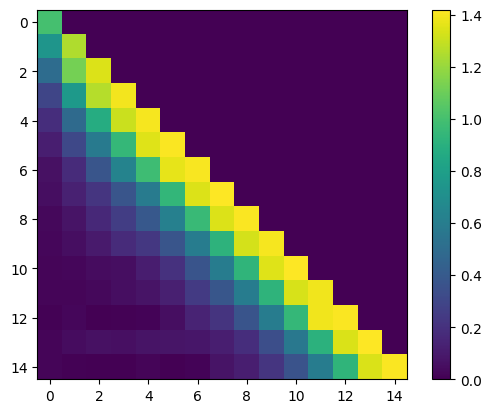

In [ ]:
image = plt.imshow(abs(L_est))
plt.colorbar(image)

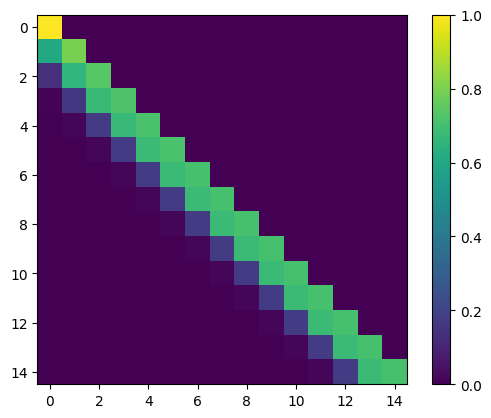

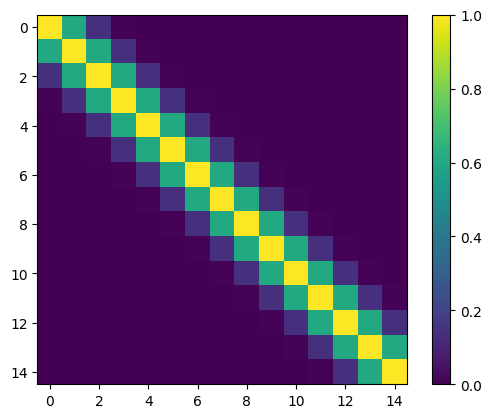

In [ ]:
A = generate_kernel_matrix(15, sigma=2.0)
L_true = np.linalg.cholesky(A)
img = plt.imshow(L_true)
plt.colorbar(img)
plt.show()
plt.colorbar(plt.imshow(A))
plt.show()

In [ ]:
np.linalg.norm((L_true@L_true.T)- A, 'fro')

4.098502480769104e-16

## Optimize by row using Cholesky

In [ ]:
import numpy as np

def newton_cholesky_band_corrected(X, m, n, max_iter=100, tol=1e-8):
    """
    Estimate the banded Cholesky factor L (with nonzeros only on the diagonal and subdiagonal)
    from data X using Newton's method applied column by column.

    For each column j, we optimize the loss
      f_j(z) = -m*log(z[0]) + (1/2)*sum_{i=1}^m ( u_i[j:j+d] dot z )^2, z[0] correspond to Ljj diagonal entry of L.
    where d = min(2, n-j) and z = L[j:j+d, j].

    This loss corresponds to the Gaussian negative log-likelihood
    when the precision matrix is given by P = L L^T.

    Parameters:
      X       : (m x n) data matrix (each row is a sample)
      m       : number of samples
      n       : dimension of the data (L is n x n)
      max_iter: maximum number of Newton iterations per column
      tol     : tolerance for the Newton step

    Returns:
      L       : estimated lower-triangular Cholesky factor (n x n), banded with bandwidth 2.
    """
    L = np.zeros((n, n))

    # Initialize L: set diagonal to 1 and the off-diagonal in the band to 0.
    for j in range(n):
        L[j, j] = 1.0

    # Process each column j
    for j in range(n):
        # For a tridiagonal L, only positions j and (if exists) j+1 are free.
        d = min(2, n - j)
        z = L[j:j+d, j].copy()  # current free parameters in column j, shape (d,)
        # Only the corresponding entries in X are needed.
        X_band = X[:, j:j+d]    # shape (m, d)

        # Newton iterations for column j.
        for it in range(max_iter):
            # Compute predictions: for each sample i, r_i = X_band[i] dot z.
            r = X_band.dot(z)  # shape (m,)

            # Compute gradient.
            # Derivative of -m*log(z[0]) is -m/z[0] (only affecting the first element).
            # Derivative of (1/2)*sum_i (r_i)^2 is X_band.T dot r.
            g = np.zeros(d)
            g[0] = -m / z[0]
            g += X_band.T.dot(r)

            # Compute Hessian.
            # Hessian from quadratic term: X_band.T dot X_band.
            H = X_band.T.dot(X_band)
            # Hessian from -log term: only the (0,0) entry gets m/(z[0]^2).
            H[0, 0] += m / (z[0]**2)

            # Solve for the Newton step: H * delta = -g.
            delta = np.linalg.solve(H, -g)
            z = z + delta

            if np.linalg.norm(delta) < tol:
                break

        # Update column j of L.
        L[j:j+d, j] = z
    return L

def compute_cholesky_estimate_corrected():
    np.random.seed(0)
    n = 5       # dimension
    m = 1000    # number of samples

    # Construct a tridiagonal precision matrix P = 2I - off-diagonals (-1).
    P = 2 * np.eye(n)
    for i in range(n - 1):
        P[i, i+1] = -1
        P[i+1, i] = -1

    # Compute the true Cholesky factor L_true via numpy.
    L_true = np.linalg.cholesky(P)
    # Covariance is the inverse of the precision.
    Sigma = np.linalg.inv(P)

    # Generate m samples from N(0, Sigma).
    X = np.random.multivariate_normal(np.zeros(n), Sigma, size=m)

    # Estimate L using the corrected Newton method.
    L_est = newton_cholesky_band_corrected(X, m, n)

    frob_error = np.linalg.norm(L_true - L_est, ord='fro')
    return L_true, L_est, frob_error

# Run the computation and save the results.
L_true, L_est, frob_error = compute_cholesky_estimate_corrected()

print("True L (from np.linalg.cholesky):\n", L_true)
print("\nEstimated L (via Newton's method):\n", L_est)
print("\nFrobenius norm error between L_true and L_est: {:.2e}".format(frob_error))

# For additional verification, check that L_true@L_true.T equals the precision matrix,
# and compare it with  L_est@L_est.T.
print("\nTrue precision matrix (L_true @ L_true.T):\n", L_true @ L_true.T)
print("\nEstimated precision matrix (L_est @ L_est.T):\n", L_est @ L_est.T)


True L (from np.linalg.cholesky):
 [[ 1.41421356  0.          0.          0.          0.        ]
 [-0.70710678  1.22474487  0.          0.          0.        ]
 [ 0.         -0.81649658  1.15470054  0.          0.        ]
 [ 0.          0.         -0.8660254   1.11803399  0.        ]
 [ 0.          0.          0.         -0.89442719  1.09544512]]

Estimated L (via Newton's method):
 [[ 1.39471999  0.          0.          0.          0.        ]
 [-0.66650448  1.24433788  0.          0.          0.        ]
 [ 0.         -0.80835034  1.19239023  0.          0.        ]
 [ 0.          0.         -0.93418005  1.15350374  0.        ]
 [ 0.          0.          0.         -0.92110573  1.10792196]]

Frobenius norm error between L_true and L_est: 1.03e-01

True precision matrix (L_true @ L_true.T):
 [[ 2. -1.  0.  0.  0.]
 [-1.  2. -1.  0.  0.]
 [ 0. -1.  2. -1.  0.]
 [ 0.  0. -1.  2. -1.]
 [ 0.  0.  0. -1.  2.]]

Estimated precision matrix (L_est @ L_est.T):
 [[ 1.94524385 -0.92958713  0. 


Theta_est for complexity 1 nonzero entries per column:

          Col 0     Col 1     Col 2     Col 3     Col 4     Col 5    Col 6  \
Row 0   0.51091  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
Row 1   0.00000  0.259927  0.000000  0.000000  0.000000  0.000000  0.00000   
Row 2   0.00000  0.000000  0.212009  0.000000  0.000000  0.000000  0.00000   
Row 3   0.00000  0.000000  0.000000  0.193059  0.000000  0.000000  0.00000   
Row 4   0.00000  0.000000  0.000000  0.000000  0.187933  0.000000  0.00000   
Row 5   0.00000  0.000000  0.000000  0.000000  0.000000  0.188527  0.00000   
Row 6   0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.18822   
Row 7   0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
Row 8   0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
Row 9   0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
Row 10  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
Row 11 

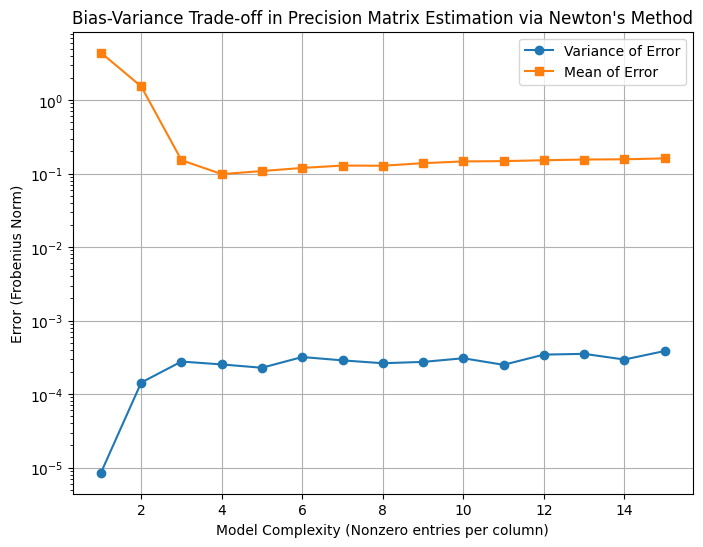

true_theta =
               0             1             2             3             4   \
0   1.000000e+00  6.065307e-01  1.353353e-01  1.110900e-02  3.354626e-04   
1   6.065307e-01  1.000000e+00  6.065307e-01  1.353353e-01  1.110900e-02   
2   1.353353e-01  6.065307e-01  1.000000e+00  6.065307e-01  1.353353e-01   
3   1.110900e-02  1.353353e-01  6.065307e-01  1.000000e+00  6.065307e-01   
4   3.354626e-04  1.110900e-02  1.353353e-01  6.065307e-01  1.000000e+00   
5   3.726653e-06  3.354626e-04  1.110900e-02  1.353353e-01  6.065307e-01   
6   1.522998e-08  3.726653e-06  3.354626e-04  1.110900e-02  1.353353e-01   
7   2.289735e-11  1.522998e-08  3.726653e-06  3.354626e-04  1.110900e-02   
8   1.266417e-14  2.289735e-11  1.522998e-08  3.726653e-06  3.354626e-04   
9   2.576757e-18  1.266417e-14  2.289735e-11  1.522998e-08  3.726653e-06   
10  1.928750e-22  2.576757e-18  1.266417e-14  2.289735e-11  1.522998e-08   
11  5.311092e-27  1.928750e-22  2.576757e-18  1.266417e-14  2.289735e-11  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_kernel_matrix(n, sigma=2.0):
    """
    Generate a Gaussian kernel matrix (which is positive definite)
    """
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A[i, j] = np.exp(-((i - j) ** 2) / sigma)
    # Ensure positive definiteness (shift if necessary)
    min_eig = np.min(np.linalg.eigvalsh(A))
    if min_eig < 1e-8:
        A += (1e-8 - min_eig) * np.eye(n)
    return A

def newton_cholesky_sparse(Y, m, n, k, max_iter=100, tol=1e-8):
    """
    Estimate the lower-triangular Cholesky factor L of the precision matrix Theta = L L^T,
    subject to a sparsity pattern that allows at most k nonzero entries per column.

    Here, the loss for column j is:
       f_j(z) = -m*log(z[0]) + (1/2)*sum_{i=1}^m ( Y[i, j:j+d] dot z )^2,
    where d = min(k, n - j) and z = L[j:j+d, j]. The samples Y are drawn from N(0, Sigma)
    with Sigma = Theta_true^{-1}.

    Parameters:
      Y       : (m x n) data matrix (each row is a sample)
      m       : number of samples
      n       : ambient dimension (L is n x n)
      k       : complexity; number of nonzero entries allowed per column in L.
      max_iter: maximum Newton iterations per column.
      tol     : tolerance for convergence.

    Returns:
      L       : estimated lower-triangular Cholesky factor (n x n), with sparsity pattern:
                for each column j, only rows j,...,min(n-1, j+k-1) may be nonzero.
    """
    L = np.zeros((n, n))
    # Initialize L: set diagonal to 1; other allowed entries start at 0.
    for j in range(n):
        L[j, j] = 1.0

    # Process each column j
    for j in range(n):
        d = min(k, n - j)  # number of free parameters in column j
        # The free part of column j
        z = L[j:j+d, j].copy()  # shape (d,)
        # Use only the corresponding columns of Y
        Y_band = Y[:, j:j+d]     # shape (m, d)

        for it in range(max_iter):
            # Prediction: for each sample i, compute r_i = Y_band[i] dot z.
            r = Y_band.dot(z)  # shape (m,)
            # Loss: f(z) = -m log(z[0]) + (1/2)*sum_i r_i^2.
            # Gradient:
            #   For the first element: -m/z[0] + (Y_band^T r)[0],
            #   For others: (Y_band^T r)[k].
            g = np.zeros(d)
            g[0] = -m / z[0]
            g += Y_band.T.dot(r)
            # Hessian: from quadratic part: Y_band^T Y_band;
            # from -log: add m/(z[0]^2) to (0,0) element.
            H = Y_band.T.dot(Y_band)
            H[0, 0] += m / (z[0]**2)

            # Newton step: solve H * delta = -g.
            delta = np.linalg.solve(H, -g)
            z = z + delta

            if np.linalg.norm(delta) < tol:
                break

        L[j:j+d, j] = z
    return L

# --- Experiment setup ---
n = 15  # matrix dimension
# Generate a "true" precision matrix from a Gaussian kernel.
true_theta = generate_kernel_matrix(n, sigma=2.0)
true_cov = np.linalg.inv(true_theta)

num_trials = 100
m = 10000   # number of samples per trial
complexities = range(1, n + 1)  # allow k = 1, 2, ..., n nonzero entries per column

variance_list = []
mean_error_list = []

# We'll also save the last estimated Theta for each complexity.
Theta_est_dict = {}

for k in complexities:
    errors = []
    # For our Newton method, the allowed sparsity pattern for L is:
    # for each column j, allowed rows: j, j+1, ..., min(n-1, j+k-1).
    # (Entries not in this block remain zero.)
    for trial in range(num_trials):
        # Generate m samples from N(0, true_cov)
        Y = np.random.multivariate_normal(np.zeros(n), true_cov, size=m)
        # Estimate the Cholesky factor L (with the given complexity k)
        L_est = newton_cholesky_sparse(Y, m, n, k)
        # Form the estimated precision: Theta_est = L_est @ L_est^T.
        Theta_est = L_est @ L_est.T
        error = np.linalg.norm(Theta_est - true_theta, 'fro')
        errors.append(error)
    Theta_est_dict[k] = Theta_est  # save last estimate for this k
    mean_error_list.append(np.mean(errors))
    variance_list.append(np.var(errors))

    # Also print the estimated Theta for this complexity as a DataFrame.
    Theta_est_df = pd.DataFrame(Theta_est,
                                columns=[f"Col {i}" for i in range(n)],
                                index=[f"Row {i}" for i in range(n)])
    print(f"\nTheta_est for complexity {k} nonzero entries per column:\n")
    print(Theta_est_df)

    # Check that the estimated L respects our sparsity pattern.
    valid = True
    for j in range(n):
        allowed = set(range(j, min(n, j+k)))
        for i in range(n):
            if i not in allowed and abs(L_est[i, j]) > 1e-8:
                valid = False
                break
        if not valid:
            break
    print(f"Constraints satisfied for complexity {k}: {valid}\n")

# Plot the mean and variance of the errors.
plt.figure(figsize=(8, 6))
plt.semilogy(complexities, variance_list, marker='o', label='Variance of Error')
plt.semilogy(complexities, mean_error_list, marker='s', label='Mean of Error')
plt.xlabel("Model Complexity (Nonzero entries per column)")
plt.ylabel("Error (Frobenius Norm)")
plt.title("Bias-Variance Trade-off in Precision Matrix Estimation via Newton's Method")
plt.legend()
plt.grid(True)
plt.show()

print("true_theta =\n", pd.DataFrame(true_theta))


## Identifying sparsity pattern from data.


Theta_est for complexity 1 nonzero entries per row:

               Col 0         Col 1         Col 2         Col 3         Col 4  \
Row 0   4.976149e-01 -1.322293e-14 -7.794396e-15  8.358530e-15 -5.984457e-15   
Row 1  -1.322293e-14  2.660575e-01  1.081632e-13 -7.201129e-14  4.644174e-14   
Row 2  -7.794396e-15  1.081632e-13  2.178091e-01  1.311902e-13 -8.928537e-14   
Row 3   8.358530e-15 -7.201129e-14  1.311902e-13  1.986322e-01  1.506019e-13   
Row 4  -5.984457e-15  4.644174e-14 -8.928537e-14  1.506019e-13  1.936294e-01   
Row 5   3.829067e-15 -2.803108e-14  5.579948e-14 -9.931381e-14  1.571576e-13   
Row 6  -2.258214e-15  1.663781e-14 -3.517669e-14  6.251057e-14 -1.064809e-13   
Row 7   1.474289e-15 -1.033965e-14  2.196462e-14 -3.838650e-14  6.615510e-14   
Row 8  -8.487277e-16  6.002161e-15 -1.383616e-14  2.318696e-14 -4.025336e-14   
Row 9   5.205924e-16 -5.118406e-15  9.374224e-15 -1.396766e-14  2.489179e-14   
Row 10 -1.150419e-15  7.180848e-15 -8.686594e-15  1.024730e-14 -1.

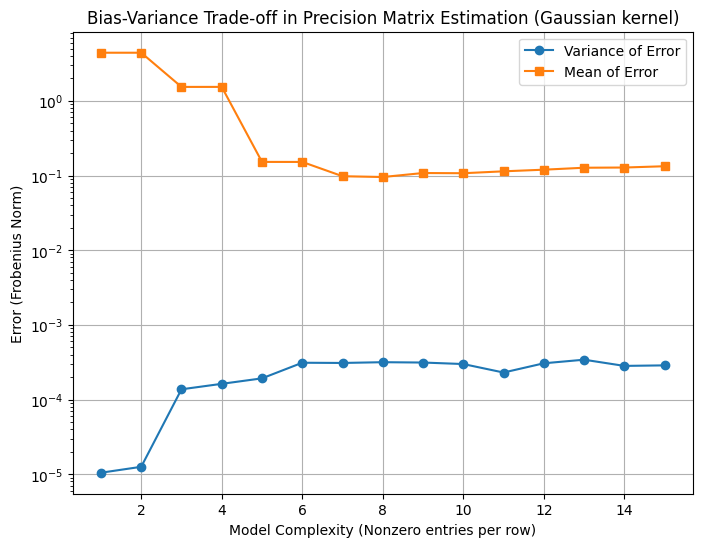

true_theta = 
               0             1             2             3             4   \
0   1.000000e+00  6.065307e-01  1.353353e-01  1.110900e-02  3.354626e-04   
1   6.065307e-01  1.000000e+00  6.065307e-01  1.353353e-01  1.110900e-02   
2   1.353353e-01  6.065307e-01  1.000000e+00  6.065307e-01  1.353353e-01   
3   1.110900e-02  1.353353e-01  6.065307e-01  1.000000e+00  6.065307e-01   
4   3.354626e-04  1.110900e-02  1.353353e-01  6.065307e-01  1.000000e+00   
5   3.726653e-06  3.354626e-04  1.110900e-02  1.353353e-01  6.065307e-01   
6   1.522998e-08  3.726653e-06  3.354626e-04  1.110900e-02  1.353353e-01   
7   2.289735e-11  1.522998e-08  3.726653e-06  3.354626e-04  1.110900e-02   
8   1.266417e-14  2.289735e-11  1.522998e-08  3.726653e-06  3.354626e-04   
9   2.576757e-18  1.266417e-14  2.289735e-11  1.522998e-08  3.726653e-06   
10  1.928750e-22  2.576757e-18  1.266417e-14  2.289735e-11  1.522998e-08   
11  5.311092e-27  1.928750e-22  2.576757e-18  1.266417e-14  2.289735e-11 

In [ ]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

def generate_kernel_matrix(n, sigma=2.0):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A[i, j] = np.exp(-((i - j) ** 2) / sigma)
    # Ensure positive definiteness
    min_eig = np.min(np.linalg.eigvalsh(A))
    if min_eig < 1e-8:
        A += (1e-8 - min_eig) * np.eye(n)
    return A


def generate_l_diagonal_matrix(n, l, diag_mean=-2, diag_std=0.5, offdiag_mean=1, offdiag_std=0.2):
    """
    Generate a random l-diagonal symmetric positive definite precision matrix of size n x n.
    """
    matrix = np.zeros((n, n))
    main_diag = np.random.normal(diag_mean, diag_std, n)
    np.fill_diagonal(matrix, main_diag)
    for band in range(1, l):
        off_diag = np.random.normal(offdiag_mean, offdiag_std, n - band)
        matrix += np.diag(off_diag, k=band) + np.diag(off_diag, k=-band)
    min_eig = np.min(np.linalg.eigvalsh(matrix))
    if min_eig <= 0:
        matrix += np.eye(n) * (0.1 - min_eig)
    return matrix

def create_sparsity_pattern(n, k):
    """
    Create a sparsity pattern with k nonzero entries per row from the diagonal outward.
    """
    sparsity_pattern = []
    half_bandwidth = (k - 1) // 2
    for i in range(n):
        indices = [i]
        for band in range(1, half_bandwidth + 1):
            if i - band >= 0:
                indices.append(i - band)
            if i + band < n:
                indices.append(i + band)
        sparsity_pattern.append(sorted(set(indices)))
    return sparsity_pattern

def estimate_theta(YTY, sparsity_pattern, n, m):
    Theta = cp.Variable((n, n), PSD=True)
    constraints = [Theta[i, j] == 0 for i in range(n) for j in range(n) if j not in sparsity_pattern[i]]
    objective = cp.Minimize(0.5 * cp.trace(Theta @ YTY) - (m / 2) * cp.log_det(Theta))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=False)
    return Theta.value

n = 15  # Matrix size
l = 5   # Half-bandwidth (5 lower + 5 upper diagonals = 9-diagonal matrix)
# true_theta = generate_l_diagonal_matrix(n, l)
true_theta = generate_kernel_matrix(n, sigma=2.0)
true_cov = np.linalg.inv(true_theta)

num_trials = 100
m = 10000   #number of samples
complexities = range(1, n + 1)

variance_list = []
mean_error_list = []

for k in complexities:
    errors = []
    sparsity_pattern = create_sparsity_pattern(n, k)
    for trial in range(num_trials):
        Y = np.random.multivariate_normal(np.zeros(n), true_cov, size=m)
        YTY = Y.T @ Y
        Theta_est = estimate_theta(YTY, sparsity_pattern, n, m)
        if Theta_est is not None:
            errors.append(np.linalg.norm(Theta_est - true_theta, 'fro'))
    Theta_est_df = pd.DataFrame(Theta_est, columns=[f"Col {i}" for i in range(n)], index=[f"Row {i}" for i in range(n)])
    print(f"\nTheta_est for complexity {k} nonzero entries per row:\n")
    print(Theta_est_df)
    is_valid = all(np.abs(Theta_est[i, j]) < 1e-8 for i in range(n) for j in range(n) if j not in sparsity_pattern[i])
    print(f"Constraints satisfied for complexity {k}: {is_valid}\n")
    variance_list.append(np.var(errors))
    mean_error_list.append(np.mean(errors))

plt.figure(figsize=(8, 6))
plt.semilogy(complexities, variance_list, marker='o', label='Variance of Error')
plt.semilogy(complexities, mean_error_list, marker='s', label='Mean of Error')
plt.xlabel("Model Complexity (Nonzero entries per row)")
plt.ylabel("Error (Frobenius Norm)")
plt.title("Bias-Variance Trade-off in Precision Matrix Estimation (Gaussian kernel)")

plt.legend()
plt.grid(True)
plt.show()

print("true_theta = \n", pd.DataFrame(true_theta))


<ipython-input-2-ca252dbc25d5>:20: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return sigma**2 * (2**(1 - nu) / np.math.gamma(nu)) * (factor**nu) * kv(nu, factor)



Theta_est for complexity 1 nonzero entries per row:

               Col 0         Col 1         Col 2         Col 3         Col 4  \
Row 0   3.542320e+00  3.387164e-11 -3.088275e-11  1.786864e-11 -1.027643e-11   
Row 1   3.387164e-11  3.140080e+00  5.732675e-11 -2.822286e-11  9.964345e-12   
Row 2  -3.088275e-11  5.732675e-11  2.436325e+00  6.405698e-11 -4.445649e-11   
Row 3   1.786864e-11 -2.822286e-11  6.405698e-11  3.267277e+00  3.381766e-11   
Row 4  -1.027643e-11  9.964345e-12 -4.445649e-11  3.381766e-11  2.317773e+00   
Row 5  -8.633436e-13  1.006293e-11  1.238677e-11 -3.205148e-12  5.857218e-11   
Row 6  -8.855495e-14  3.736988e-12 -6.158576e-12  5.592560e-12 -6.248261e-12   
Row 7  -9.464988e-12  1.462005e-11  6.070152e-12  8.014073e-12  1.955101e-12   
Row 8   3.187848e-13 -1.113239e-11 -8.342952e-12  1.271129e-11  4.501935e-12   
Row 9   1.483881e-12 -1.422150e-11  8.983343e-12 -1.412516e-11 -8.653017e-12   
Row 10  4.202355e-12  1.897776e-11 -2.424065e-11  1.119236e-11 -1.

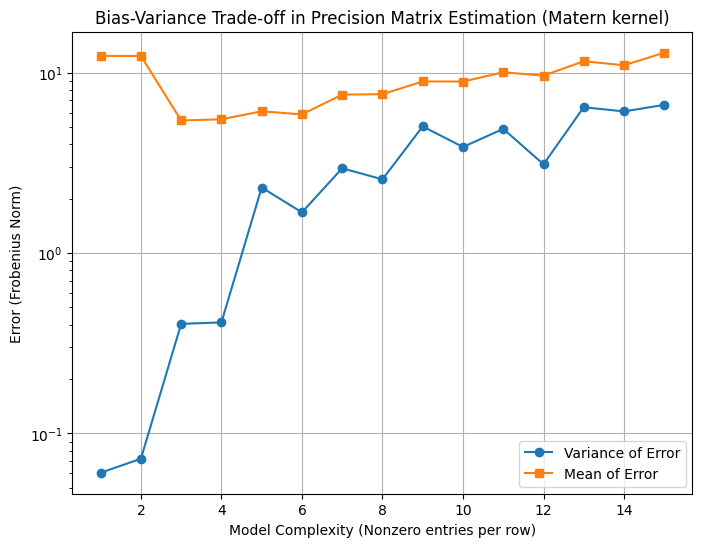

true_theta = 
               0             1             2             3         4   \
0   4.000000e+00  1.933431e+00  5.589254e-01  1.372530e-01  0.031071   
1   1.933431e+00  4.000000e+00  1.933431e+00  5.589254e-01  0.137253   
2   5.589254e-01  1.933431e+00  4.000000e+00  1.933431e+00  0.558925   
3   1.372530e-01  5.589254e-01  1.933431e+00  4.000000e+00  1.933431   
4   3.107094e-02  1.372530e-01  5.589254e-01  1.933431e+00  4.000000   
5   6.698044e-03  3.107094e-02  1.372530e-01  5.589254e-01  1.933431   
6   1.397497e-03  6.698044e-03  3.107094e-02  1.372530e-01  0.558925   
7   2.848375e-04  1.397497e-03  6.698044e-03  3.107094e-02  0.137253   
8   5.704438e-05  2.848375e-04  1.397497e-03  6.698044e-03  0.031071   
9   1.126899e-05  5.704438e-05  2.848375e-04  1.397497e-03  0.006698   
10  2.201894e-06  1.126899e-05  5.704438e-05  2.848375e-04  0.001397   
11  4.263916e-07  2.201894e-06  1.126899e-05  5.704438e-05  0.000285   
12  8.195368e-08  4.263916e-07  2.201894e-06  1.1

In [ ]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from scipy.special import kv  # Modified Bessel function of the second kind

def matern_kernel(d, nu=1.5, l=1.0, sigma=2.0):
    """
    Matérn kernel function.
    d : distance matrix
    nu : smoothness parameter
    l : length scale
    sigma : variance parameter
    """
    if d == 0.0:
        return sigma**2
    factor = np.sqrt(2 * nu) * d / l
    return sigma**2 * (2**(1 - nu) / np.math.gamma(nu)) * (factor**nu) * kv(nu, factor)

def generate_matern_kernel_matrix(n, nu=1.5, l=1.0, sigma=2.0):
    """
    Generate an n x n Matérn kernel matrix.
    """
    # Generate distances
    x = np.arange(n).reshape(-1, 1)
    dists = squareform(pdist(x, 'euclidean'))

    A = np.vectorize(lambda d: matern_kernel(d, nu, l, sigma))(dists)

    # Ensure positive definiteness
    min_eig = np.min(np.linalg.eigvalsh(A))
    if min_eig < 1e-8:
        A += (1e-8 - min_eig) * np.eye(n)
    return A


def create_sparsity_pattern(n, k):
    """
    Create a sparsity pattern with k nonzero entries per row from the diagonal outward.
    """
    sparsity_pattern = []
    half_bandwidth = (k - 1) // 2
    for i in range(n):
        indices = [i]
        for band in range(1, half_bandwidth + 1):
            if i - band >= 0:
                indices.append(i - band)
            if i + band < n:
                indices.append(i + band)
        sparsity_pattern.append(sorted(set(indices)))
    return sparsity_pattern

def estimate_theta(YTY, sparsity_pattern, n, m):
    Theta = cp.Variable((n, n), PSD=True)
    constraints = [Theta[i, j] == 0 for i in range(n) for j in range(n) if j not in sparsity_pattern[i]]
    objective = cp.Minimize(0.5 * cp.trace(Theta @ YTY) - (m / 2) * cp.log_det(Theta))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=False)
    return Theta.value

n = 15  # Matrix size
l = 5   # Half-bandwidth (5 lower + 5 upper diagonals = 9-diagonal matrix)
# true_theta = generate_l_diagonal_matrix(n, l)
true_theta = generate_matern_kernel_matrix(n, nu=1.5, l=1.0, sigma=2.0)
true_cov = np.linalg.inv(true_theta)

num_trials = 100
m = 50
complexities = range(1, n + 1)

variance_list = []
mean_error_list = []

for k in complexities:
    errors = []
    sparsity_pattern = create_sparsity_pattern(n, k)
    for trial in range(num_trials):
        Y = np.random.multivariate_normal(np.zeros(n), true_cov, size=m)
        YTY = Y.T @ Y
        Theta_est = estimate_theta(YTY, sparsity_pattern, n, m)
        if Theta_est is not None:
            errors.append(np.linalg.norm(Theta_est - true_theta, 'fro'))
    Theta_est_df = pd.DataFrame(Theta_est, columns=[f"Col {i}" for i in range(n)], index=[f"Row {i}" for i in range(n)])
    print(f"\nTheta_est for complexity {k} nonzero entries per row:\n")
    print(Theta_est_df)
    is_valid = all(np.abs(Theta_est[i, j]) < 1e-8 for i in range(n) for j in range(n) if j not in sparsity_pattern[i])
    print(f"Constraints satisfied for complexity {k}: {is_valid}\n")
    variance_list.append(np.var(errors))
    mean_error_list.append(np.mean(errors))

plt.figure(figsize=(8, 6))
plt.semilogy(complexities, variance_list, marker='o', label='Variance of Error')
plt.semilogy(complexities, mean_error_list, marker='s', label='Mean of Error')
plt.xlabel("Model Complexity (Nonzero entries per row)")
plt.ylabel("Error (Frobenius Norm)")
plt.title("Bias-Variance Trade-off in Precision Matrix Estimation (Matern kernel)")

plt.legend()
plt.grid(True)
plt.show()

print("true_theta = \n", pd.DataFrame(true_theta))

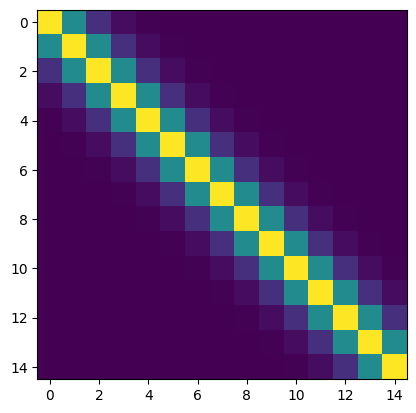

In [ ]:
plt.imshow(true_theta)